# Read and Explore Data

In [1]:
import sys
sys.path.append("../")

import numpy as np
import pandas as pd
from typing import Union, Tuple
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
from task1.retrieval_system import RetrievalSystem, SongInfo
from task1.similarity_measure import (
    cosine_similarity,
    dot_product,
    manhattan_distance,
    euclidean_distance,
    random_similarity,
)
from utils import read, embed_and_merge

In [3]:
# basic song information from task 1
df = read("information", 0)
df

,id,artist,song,album_name
0,01Yfj2T3YTwJ1Yfy,We As Human,Take The Bullets Away (feat. Lacey Sturm),We As Human
1,01gyRHLquwXDlhkO,The Notorious B.I.G.,Somebody's Gotta Die,Life After Death (Remastered Edition)
2,01rMxQv6vhyE1oQX,Against the Current,Chasing Ghosts,In Our Bones
3,02RGE9FNH65RtMS7,Barthezz,Infected,Trance - The Early Years (1997-2002)
4,02ZnlCGZEbkfCDxo,Laura Pausini,Tra Te E Il Mare,The Best of Laura Pausini - E Ritorno Da Te
...,...,...,...,...
10090,zyzILCQvVeUFIINi,Crowded House,When You Come,Temple Of Low Men
10091,zzgS4ZqyswamEWNj,Britney Spears,My Only Wish (This Year),Platinum Christmas
10092,zzoFYDMlqU1X2zz1,Thundercat,DUI,Drunk
10093,zzpkRCGA5ud8q4mv,Otis Redding,Rock Me Baby,Otis Blue


In [4]:
# add genre information for metric calculation
genres = read("genres", 0)
# convert genre to actual list via eval
genres["genre"] = genres["genre"].apply(eval).apply(set)
df = df.merge(genres, on="id", how="left")

We load the following features:
- MFCCs in BoW form,
- Spectral BLFs,
- 256-dimensional i-vectors,
- 1024-dimensional i-vectors,
- DNN-based features (musicnn).

In [5]:
for feature in ["mfcc_bow", "blf_spectral", "ivec256", "ivec1024", "musicnn"]:
    stats = read(feature, 0)
    df = embed_and_merge(df, stats, feature)

... and also those from the previous assignment:

In [6]:
for text_feature in ["lyrics_bert", "lyrics_word2vec", "lyrics_tf-idf"]:
    stats = read(text_feature, 0)
    df = embed_and_merge(df, stats, text_feature.split("_")[1])

In [7]:
df.isna().sum()

id              0
artist          0
song            0
album_name      0
genre           1
mfcc_bow        1
blf_spectral    1
ivec256         1
ivec1024        1
musicnn         1
bert            0
word2vec        0
tf-idf          0
dtype: int64

In [8]:
df[df.isna().any(axis=1)]

,id,artist,song,album_name,genre,mfcc_bow,blf_spectral,ivec256,ivec1024,musicnn,bert,word2vec,tf-idf
5,03Oc9WeMEmyLLQbj,Shakira,Costume Makes the Clown,"Oral Fixation, Vol. 2 (Expanded Edition)",NaN,NaN,NaN,NaN,NaN,NaN,"[0.042631160467863, 0.0509439371526241, -0.026...","[0.0173026816431956, 0.0238044851088488, 0.013...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [9]:
df["mfcc_bow"].values[1].shape

(500,)

In [10]:
# data for task 2 does not include the item with id "03Oc9WeMEmyLLQbj" = row 5
df = df.drop(5)
df = df.reset_index()

# Define retrieval systems

## From Task 1 (text-based)

In [11]:
rs_random = RetrievalSystem(
    df=df,
    sim_metric=random_similarity,
)

In [12]:
rs_cos_tdidf = RetrievalSystem(
    df=df,
    sim_metric=cosine_similarity,
    sim_feature="tf-idf",
)

In [13]:
rs_cos_bert = RetrievalSystem(
    df=df,
    sim_metric=cosine_similarity,
    sim_feature="bert",
)

In [14]:
rs_dot_w2v = RetrievalSystem(
    df=df,
    sim_metric=dot_product,
    sim_feature="word2vec",
)

## From Task 2 (audio-based; new!)

In [15]:
rs_cos_mfcc = RetrievalSystem(
    df=df,
    sim_metric=cosine_similarity,
    sim_feature="mfcc_bow",
)

In [16]:
rs_cos_blf = RetrievalSystem(
    df=df,
    sim_metric=cosine_similarity,
    sim_feature="blf_spectral",
)

In [17]:
rs_cos_ivec256 = RetrievalSystem(
    df=df,
    sim_metric=cosine_similarity,
    sim_feature="ivec256",
)

In [18]:
rs_cos_dnn = RetrievalSystem(
    df=df,
    sim_metric=cosine_similarity,
    sim_feature="musicnn",
)

In [19]:
# create pd dataframe consisting of all retrieval systems, with metric and feature
rs = pd.DataFrame(
    [
        ["random", "random", rs_random],
        ["cosine", "tf-idf", rs_cos_tdidf],
        ["cosine", "bert", rs_cos_bert],
        ["dot", "word2vec", rs_dot_w2v],
        ["cosine", "mfcc_bow", rs_cos_mfcc],
        ["cosine", "blf_spectral", rs_cos_blf],
        ["cosine", "ivec256", rs_cos_ivec256],
        ["cosine", "musicnn", rs_cos_dnn],
    ],
    columns=["metric", "feature", "rs_object"],
)

In [20]:
rs

,metric,feature,rs_object
0,random,random,<task1.retrieval_system.RetrievalSystem object...
1,cosine,tf-idf,<task1.retrieval_system.RetrievalSystem object...
2,cosine,bert,<task1.retrieval_system.RetrievalSystem object...
3,dot,word2vec,<task1.retrieval_system.RetrievalSystem object...
4,cosine,mfcc_bow,<task1.retrieval_system.RetrievalSystem object...
5,cosine,blf_spectral,<task1.retrieval_system.RetrievalSystem object...
6,cosine,ivec256,<task1.retrieval_system.RetrievalSystem object...
7,cosine,musicnn,<task1.retrieval_system.RetrievalSystem object...


# Evaluation Criteria

For the sake of completeness, we also show how we can calculate precision and recall independently for a given single query.

## Precision@k & Recall@k

In [21]:
def precision_at_k_single(
    query: pd.Series, retrieved_tracks: pd.DataFrame, k: int
) -> float:
    """Precision at k for a single query song.

    Args:
        query (pd.Series): Query song.
        retrieved_tracks (pd.DataFrame): Retrieved tracks. 
        k (int): Number of retrieved tracks to consider.

    Raises:
        ValueError: k must be smaller than the number of retrieved tracks.

    Returns:
        float: Precision at k.
    
    """
    # Filter the retrieved tracks to top k
    retrieved_tracks = retrieved_tracks.head(k)

    if k > len(retrieved_tracks):
        raise ValueError(
            f"k must be smaller than the number of retrieved tracks ({len(retrieved_tracks)})"
        )

    relevant_items_retrieved = sum(
        1
        for _, track in retrieved_tracks.head(k).iterrows()
        if query["genre"] & track["genre"]
    )
    return relevant_items_retrieved / k

In [22]:
def recall_at_k_single(
    query: pd.Series, retrieved_tracks: pd.DataFrame, k: int
) -> float:
    """Recall at k for a single query song.
    Note that we normalize by the *total* number of relevant items in the dataset.
    Args:
        query (pd.Series): Query song.
        retrieved_tracks (pd.DataFrame): Retrieved tracks. 
        k (int): Number of retrieved tracks to consider.
    Raises:
        ValueError: k must be smaller than the number of retrieved tracks.
        
    Returns:
        float: Recall at k.
    """
    # Filter the retrieved tracks to top k
    retrieved_tracks = retrieved_tracks.head(k)

    if k > len(retrieved_tracks):
        raise ValueError(
            f"k must be smaller than the number of retrieved tracks ({len(retrieved_tracks)})"
        )

    relevant_items_retrieved = sum(
        1
        for _, track in retrieved_tracks.head(k).iterrows()
        if query["genre"] & track["genre"]
    )

    relevant_items = sum(
        1 for _, track in df.iterrows() if set(query["genre"]) & set(track["genre"])
    )
    return relevant_items_retrieved / relevant_items

In [23]:
sample_song = SongInfo(title="Zombie", artist="The Cranberries")
# query most be a pd.Series --> convert here
sample_query = df[
    (df["song"] == sample_song.title) & (df["artist"] == sample_song.artist)
].iloc[0]

In [24]:
sample_query.genre

{'alternative rock',
 'celtic',
 'celtic rock',
 'classic rock',
 'grunge',
 'hard rock',
 'indie rock',
 'irish rock',
 'metal',
 'pop',
 'pop rock',
 'post grunge',
 'rock',
 'soft rock'}

In [25]:
results = rs_cos_dnn.retrieve(sample_song, 10)

In [26]:
results

,index,id,artist,song,album_name,genre,mfcc_bow,blf_spectral,ivec256,ivec1024,musicnn,bert,word2vec,similarity
0,790,4glaLmaXFAdOw5b2,Kristen Barry,Ordinary Life,Cruel Intentions,"{singer songwriter, indie rock, soft rock, sou...","[0.7781513000000001, 0.0, 2.3242824, 0.0, 1.17...","[-0.0281731, -0.019438, -0.017372, -0.0138386,...","[0.9454425573349, 1.2708547115325928, 0.325989...","[-0.0687375515699386, -1.0911340713500977, -0....","[0.4182759, 0.007046508, 0.18775995, 0.0074302...","[-0.0004561332461889, 0.0145782874897122, -0.0...","[0.0201837079373767, 0.0221617151968885, 0.016...",0.987132
1,4469,RQJ8biiC0Ed7MKyY,Shakira,Sale el Sol,Sale el Sol,"{singer songwriter, latin pop, latin rock, wor...","[1.7160033, 0.0, 2.667453, 0.0, 1.1139433, 0.0...","[-0.0238793, -0.0183009, -0.0153329, -0.013102...","[1.8669582605361936, 1.892633914947509, -1.045...","[1.905163645744324, -1.7262425422668457, 0.853...","[0.36982688, 0.009932475, 0.18211164, 0.019003...","[0.0123901953920722, 0.0618347860872745, 0.001...","[0.0206834120802038, 0.0080418127259084, 0.011...",0.985367
2,9954,z14vWV00cAGeBT9P,Céu,Lenda,CéU,"{vocal jazz, mpb, singer songwriter, reading, ...","[1.3222193000000002, 0.0, 2.146128, 0.0, 2.096...","[-0.0258737, -0.0207687, -0.0182119, -0.015643...","[1.7744811773300169, 1.3900917768478394, -0.28...","[0.2054368406534195, -1.1734609603881836, 0.06...","[0.2876089, 0.00694283, 0.09736701, 0.02208063...","[0.0605621598660945, 0.0248984489589929, -0.02...","[0.0354904266487643, 0.009812428646477, 0.0021...",0.985336
3,386,29oADILKxhOHvgvQ,Lucy Dacus,Troublemaker Doppelgänger,No Burden,"{indie folk, indie rock}","[1.7923917, 0.0, 2.0293837, 0.0, 2.6374898, 0....","[-0.0402956, -0.034032, -0.031251, -0.029338, ...","[0.5575369000434875, 1.3157860040664673, 0.573...","[0.6444730758666992, -1.242782711982727, -0.70...","[0.32060316, 0.0129062785, 0.13242425, 0.02154...","[0.0196989458054304, 0.0582268238067626, 0.001...","[0.0193930917207513, 0.0224321799395334, 0.008...",0.984114
4,7650,lBbxNiUrl7pF1H4c,Kadebostany,Castle in the Snow,Pop Collection,"{rock, pop}","[0.7781513000000001, 0.0, 1.462398, 0.0, 1.301...","[-0.0240562, -0.0197435, -0.0169551, -0.013990...","[1.3591880798339844, 0.6209864020347595, 0.309...","[1.3591336011886597, -0.4918332695960999, -0.4...","[0.27542847, 0.0085207485, 0.17537211, 0.01616...","[-0.0136576881632208, 0.0381329879164695, 0.00...","[0.0169709496347023, 0.0083717900892431, -0.02...",0.983854
5,1584,9SUQfSsDIBOh3QSV,Priscilla Ahn,Masters In China,A Good Day,"{singer songwriter, soul, folk}","[1.50515, 0.0, 1.462398, 0.0, 2.30103, 0.0, 1....","[-0.0191349, -0.0124968, -0.0088663, -0.006168...","[2.129467725753784, 1.0896250009536743, 0.6828...","[2.1317338943481445, -0.8425770401954651, -0.9...","[0.42481366, 0.0026636927, 0.19867267, 0.00749...","[0.0182842426002025, 0.0133442115038633, -0.02...","[0.0165479896808019, 0.0139839527770303, 0.010...",0.983130
6,9669,xEbmBtcR1wQcnk3y,Julieta Venegas,Oleada,Si,"{latin pop, latin, pop, rock, rock en espanol,...","[2.3873900000000003, 0.0, 2.469822, 0.0, 2.176...","[-0.0160536, -0.0104534, -0.00665913, -0.00423...","[1.5788124799728394, 1.6625230312347412, 0.228...","[1.014309287071228, -1.466999053955078, -0.471...","[0.44143254, 0.0077322265, 0.21047759, 0.00914...","[0.0002455622889101, 0.0310425776988267, -0.01...","[0.0073746261101526, 0.0089111965646346, 0.022...",0.982718
7,1147,6vbf44Iw7PzRxUWH,Taylor Swift,The Best Day,Fearless,"{country pop, singer songwriter, world, disney...","[2.1760912, 0.0, 2.409933, 0.0, 2.348304700000...","[-0.0254457, -0.0206701, -0.0167254, -0.014913...","[-0.5983439087867737, 1.6506197452545166, -0.1...","[-0.1132917702198028, -1.7878351211547852, 0.0...","[0.4190213, 0.006415901, 0.16974963, 0.0041287...","[0.0102109359577298, 0.0159489773213863, -0.01...","[0.0060818882261895, 0.0110121118431694, 0.005...",0.982597
8,9008,tJHK6mqbsr1ebi7Z,Shania Twain,Dance With The One That Brought You,Shania Twain,{countr

In [27]:
for res in results.genre:
    if sample_query.genre & res:
        print("match:", sample_query.genre & res)

match: {'indie rock', 'pop', 'soft rock'}
match: {'alternative rock', 'soft rock', 'pop', 'pop rock', 'rock'}
match: {'indie rock'}
match: {'rock', 'pop'}
match: {'rock', 'pop'}
match: {'pop rock', 'pop'}
match: {'pop'}


In [28]:
precision_at_k_single(sample_query, results, 10)

0.7

In [29]:
recall_at_k_single(sample_query, results, 10)

0.000902178115736564

However, we can simplify & speed up the calculation by:
- Creating a genre overlap matrix. Since we consider a track to be relevant if query and retrieved track have one or more genre in common, we can pre-calculate these for speed. This is especially helpful for the recall, as we have to get the full matches for every query (create_genre_overlap_matrix).
- Combine precision and recall into a single function (combined_rec_prec_at_k_single).

In [30]:
def create_genre_overlap_matrix(songs_df: pd.DataFrame) -> pd.DataFrame:
    """
    Create an optimized DataFrame representing the genre overlap between each pair of songs.
    Args:
        songs_df (pd.DataFrame): DataFrame containing the songs.
        
    Returns:
        pd.DataFrame: DataFrame with genre overlap between each pair of songs.
    """
    # Create a dictionary for faster access
    genre_dict = songs_df.set_index("id")["genre"].to_dict()

    # init empty matrix
    overlap_matrix = pd.DataFrame(
        index=songs_df["id"], columns=songs_df["id"], dtype=bool
    )

    for song_id, genres in genre_dict.items():
        overlap_matrix.loc[song_id] = [
            bool(genres & genre_dict[other_id]) for other_id in songs_df["id"]
        ]

    return overlap_matrix

In [31]:
genre_overlap_matrix = create_genre_overlap_matrix(df)
genre_overlap_matrix.head(10)

id,01Yfj2T3YTwJ1Yfy,01gyRHLquwXDlhkO,01rMxQv6vhyE1oQX,02RGE9FNH65RtMS7,02ZnlCGZEbkfCDxo,04OjszRi9rC5BlHC,04iitW3ffa0mhpx3,04xUDjAYC14jsHyH,06HvNTU9M9lnH71I,06L9OJ5nRqKnO2q9,...,zxI0u8m0EPvVhNeD,zxYtSeZzEVgPczJz,zxlnGZoud2KCmSaw,zyxOCKcXX1RmWpm0,zyz0UbYN4n9rHXex,zyzILCQvVeUFIINi,zzgS4ZqyswamEWNj,zzoFYDMlqU1X2zz1,zzpkRCGA5ud8q4mv,zzx8CWdM7qkxKQpC
id,,,,,,,,,,,,,,,,,,,,,
01Yfj2T3YTwJ1Yfy,True,False,True,False,False,True,False,False,False,False,...,True,True,True,True,False,True,True,False,True,True
01gyRHLquwXDlhkO,False,True,False,False,False,False,True,False,False,False,...,False,False,False,False,True,False,False,False,False,False
01rMxQv6vhyE1oQX,True,False,True,False,False,True,False,False,False,False,...,True,True,True,True,False,True,True,False,True,True
02RGE9FNH65RtMS7,False,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
02ZnlCGZEbkfCDxo,False,False,False,False,True,True,True,False,True,False,...,True,False,False,True,True,True,True,False,False,False
04OjszRi9rC5BlHC,True,False,True,False,True,True,True,False,False,False,...,True,True,True,True,True,True,True,False,True,True
04iitW3ffa0mhpx3,False,True,False,False,True,True,True,False,False,False,...,True,False,True,True,True,True,True,False,True,True
04xUDjAYC14jsHyH,False,False,False,False,False,False,False,True,False,False,...,False,True,False,False,False,False,False,False,False,True
06HvNTU9M9lnH71I,False,False,False,False,True,False,False,False,True,False,...,False,False,False,True,False,False,False,True,False,False


In [32]:
def combined_rec_prec_at_k_single(query_id: str, retrieved_tracks: pd.DataFrame, k: int, overlap_matrix: pd.DataFrame) -> Tuple[float, float]:
    """Combined precision and recall at k for a single query song.

    Args:
        query_id (str): Query song id.
        retrieved_tracks (pd.DataFrame): The retrieved tracks of an RS.
        k (int): Number of retrieved tracks to consider.
        overlap_matrix (pd.DataFrame): The genre overlap matrix.

    Raises:
        ValueError: k must be smaller than or equal to the number of retrieved tracks.

    Returns:
        Tuple[float, float]: Precision and recall at k.
    """
    if k > len(retrieved_tracks):
        raise ValueError(
            f"k must be smaller than or equal to the number of retrieved tracks ({len(retrieved_tracks)})"
        )

    # Filter the retrieved tracks to top k
    retrieved_tracks = retrieved_tracks.head(k)

    # Count relevant items in top k using the overlap matrix
    relevant_items_retrieved = overlap_matrix.loc[query_id, retrieved_tracks["id"]].sum()

    # Count total relevant items in the dataset using the overlap matrix
    relevant_items_total = overlap_matrix.loc[query_id].sum()

    precision = relevant_items_retrieved / k
    recall = (
        relevant_items_retrieved / relevant_items_total
        if relevant_items_total > 0
        else 0
    )

    return precision, recall

In [33]:
precision, recall = combined_rec_prec_at_k_single(
    sample_query["id"], rs_cos_dnn.retrieve(sample_song, 10), 10, genre_overlap_matrix
)
precision, recall

(0.7, 0.000902178115736564)

We can see that we get the same results.

## nDCG@10

In [34]:
def sorensen_dice_genres(genre1: set, genre2: set) -> float:
    """Calculate the Sorensen-Dice coefficient for two sets of genres.
    Args:
        genre1 (set): First set of genres.
        genre2 (set): Second set of genres.
    Returns:
        float: Sorensen-Dice coefficient.
    """
    return 2 * len(genre1 & genre2) / (len(genre1) + len(genre2))

In [35]:
def calculate_dcg(sample_query: pd.Series, retrieved_tracks: pd.DataFrame, k: int) -> float:
    """Calculate DCG for a single query song.
    Args:
        sample_query (pd.Series): Query song.
        retrieved_tracks (pd.DataFrame): Retrieved tracks. 
        k (int): Number of retrieved tracks to consider.
    Returns:
        float: DCG@k
    """
    # Vectorized calculation of relevance scores
    relevance_scores = retrieved_tracks['genre'].apply(lambda x: sorensen_dice_genres(sample_query["genre"], x))
    top_k_scores = relevance_scores.head(k).values

    denominators = np.log2(np.arange(2, k + 1))  # Starts from 2 since log2(1) is 0 and it's used for the first item
    return top_k_scores[0] + sum(top_k_scores[1:] / denominators)

In [36]:
# test
calculate_dcg(sample_query, results, 10)


0.9926746644813018

In [37]:


def calculate_idcg(sample_query: pd.Series, k: int) -> float:
    """Calculate IDCG for a single query song.
    Args:
        sample_query (pd.Series): Query song.
        k (int): Number of retrieved tracks to consider.
        
    Returns:
        float: IDCG@k
    """
    # Vectorized calculation of relevance scores
    relevance_scores = df['genre'].apply(lambda x: sorensen_dice_genres(sample_query["genre"], x))
    # sort and take top k
    sorted_scores = relevance_scores.sort_values(ascending=False).head(k).values

    # normalize by log2 of rank
    denominators = np.log2(np.arange(2, k + 1))
    return sorted_scores[0] + sum(sorted_scores[1:] / denominators)


In [38]:
calculate_idcg(sample_query, 10)

3.9121303227676525

In [39]:
def ndcg_at_k_single(
    sample_query: pd.Series, retrieved_tracks: pd.DataFrame, k: int
) -> float:
    """NDCG@k for a single query song.
    Args:
        sample_query (pd.Series): Query song.
        retrieved_tracks (pd.DataFrame): Retrieved tracks. 
        k (int): Number of retrieved tracks to consider.
    Returns:
        float: NDCG@k
    """
    if k > len(retrieved_tracks):
        raise ValueError(
            f"k must be smaller than the number of retrieved tracks ({len(retrieved_tracks)})"
        )
        
    retrieved_tracks = retrieved_tracks.head(k)
    return calculate_dcg(sample_query, retrieved_tracks, k) / calculate_idcg(
        sample_query, k
    )

In [40]:
ndcg_at_k_single(sample_query, results, 10)

0.25374273927025776

## Evaluate systems

In [44]:
import numpy as np


def calc_metrics(rs: RetrievalSystem, k1: int, k2: int, step: int) -> pd.DataFrame:
    """Calculate mean precision@k and recall@k for all queries in the dataset.
    
    Args:
        rs (RetrievalSystem): The retrieval system.
        k1 (int): The maximum k.
        k2 (int): The minimum k.
        step (int): The step size.
    
    Returns:
        pd.DataFrame: DataFrame containing the mean precision@k and recall@k.
    """
    num_queries = len(rs.df)
    k_values = list(range(k2, k1 - 1, -step))
    if k1 not in k_values:
        k_values.append(k1)
    recall_array = np.zeros(len(k_values))
    precision_array = np.zeros(len(k_values))
    ndcg = 0

    for _, query in tqdm(rs.df.iterrows(), total=num_queries):
        # Retrieve all results once for the max k
        all_retrieved_tracks = rs.retrieve(query["id"], k2)

        for i, k in enumerate(k_values):
            retrieved_tracks = all_retrieved_tracks[:k]
            precision, recall = combined_rec_prec_at_k_single(
                query["id"], retrieved_tracks, k, genre_overlap_matrix
            )
            precision_array[i] += precision
            recall_array[i] += recall
        
        # ndcg 
        ndcg += ndcg_at_k_single(query, all_retrieved_tracks[:10], 10)

    # Convert sums to means
    recall_array /= num_queries
    precision_array /= num_queries
    ndcg /= num_queries

    return pd.DataFrame(
        {"k": k_values, "recall": recall_array, "precision": precision_array, "ndcg10": ndcg}
    ).set_index("k")  
    

In [45]:
K1 = 1
K2 = 100
STEP = 5

Calculating metrics for random with random...


100%|██████████| 10094/10094 [03:25<00:00, 49.16it/s]


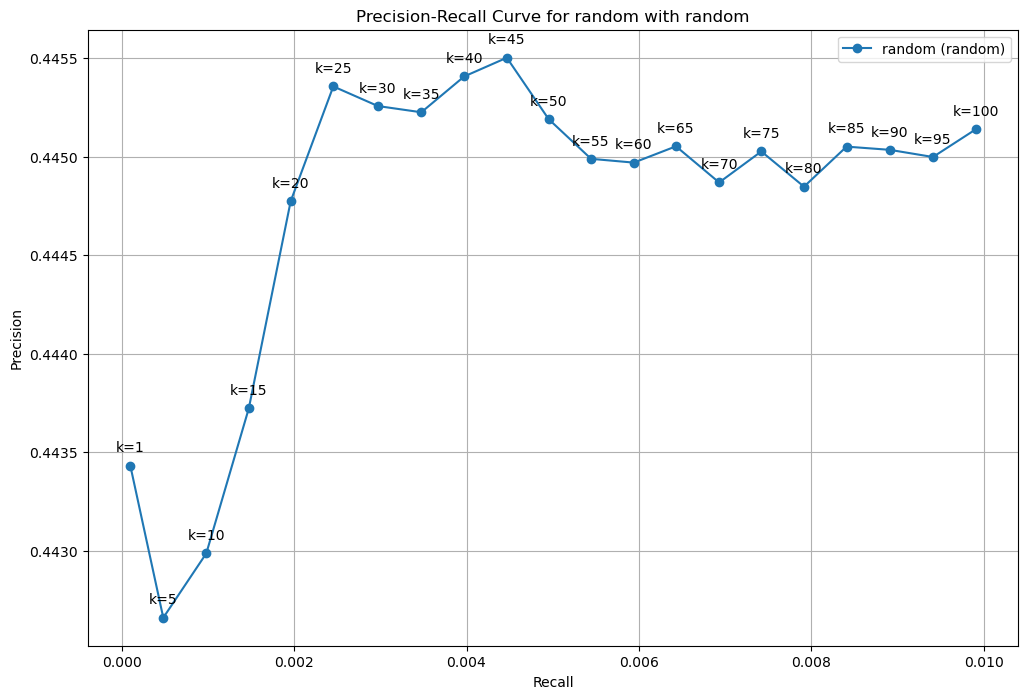

Calculating metrics for cosine with tf-idf...


100%|██████████| 10094/10094 [03:26<00:00, 48.85it/s]


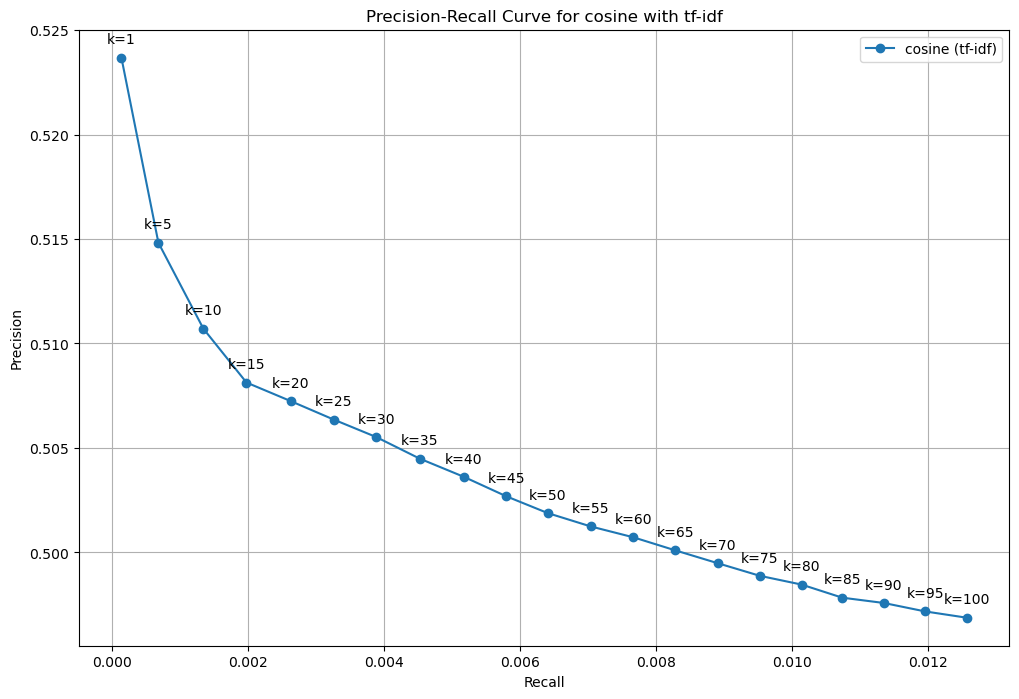

Calculating metrics for cosine with bert...


100%|██████████| 10094/10094 [07:44<00:00, 21.74it/s]


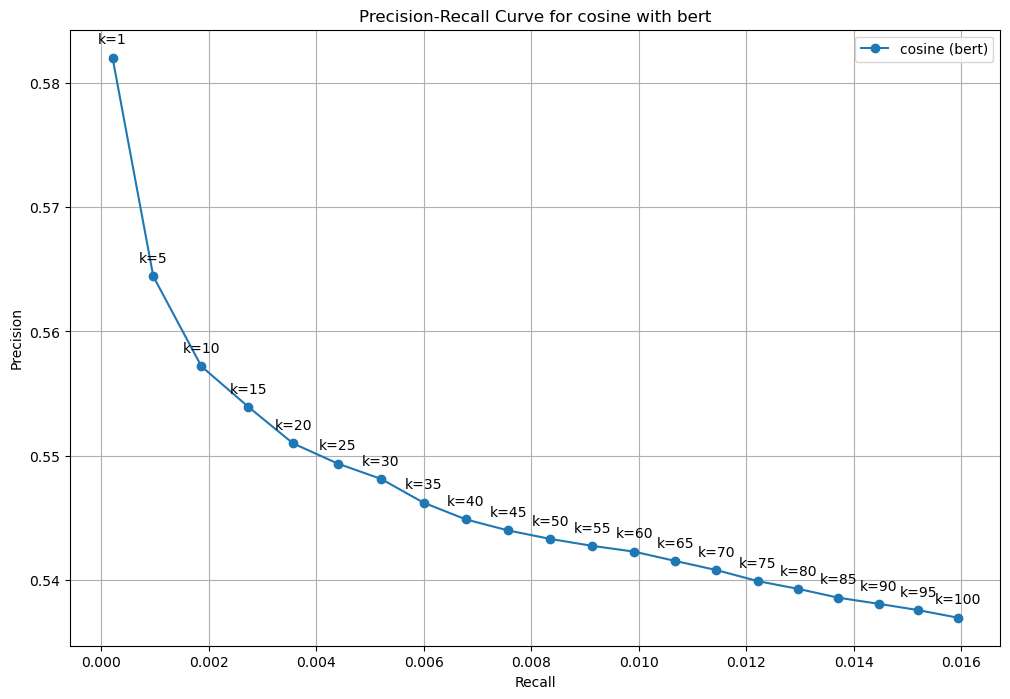

Calculating metrics for dot with word2vec...


100%|██████████| 10094/10094 [04:53<00:00, 34.41it/s]


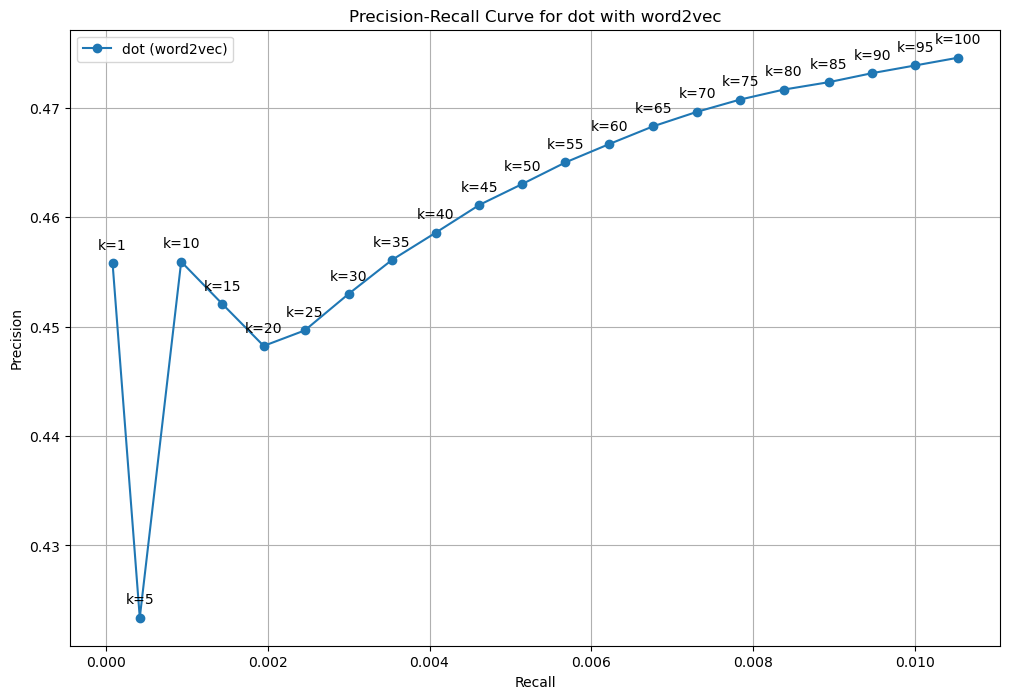

Calculating metrics for cosine with mfcc_bow...


100%|██████████| 10094/10094 [06:28<00:00, 25.97it/s]


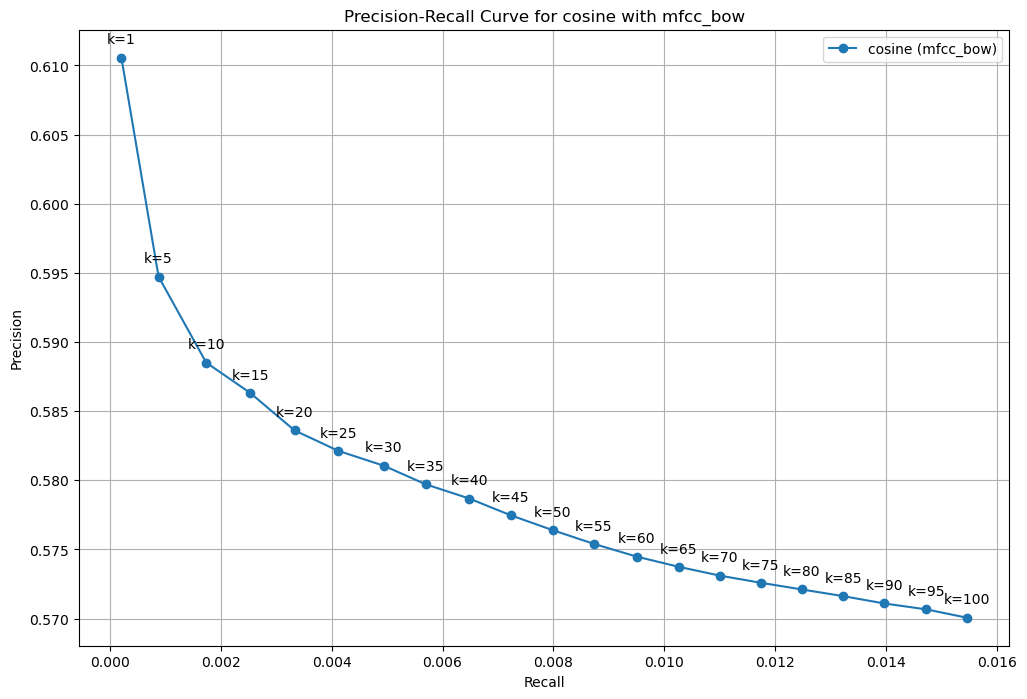

Calculating metrics for cosine with blf_spectral...


 27%|██▋       | 2675/10094 [03:30<32:40,  3.78it/s]  

: 

In [52]:
rs['metrics'] = None

for index, row in rs.iterrows():
    rs_object = row['rs_object']
    metric_name = row['metric']
    feature_name = row['feature']
    print(f"Calculating metrics for {metric_name} with {feature_name}...")

    # Calculate metrics
    metrics_df = calc_metrics(rs_object, k1=K1, k2=K2, step=STEP)

    # Store the metrics DataFrame in the rs DataFrame
    rs.at[index, 'metrics'] = metrics_df


    # Plotting
    plt.figure(figsize=(12, 8))
    plt.plot(metrics_df['recall'], metrics_df['precision'], marker='o', label=f"{metric_name} ({feature_name})")

    # Annotate each point with its k value
    for k, recall, precision in zip(metrics_df.index, metrics_df['recall'], metrics_df['precision']):
        plt.annotate(f"k={k}", (recall, precision), textcoords="offset points", xytext=(0,10), ha='center')

    plt.title(f'Precision-Recall Curve for {metric_name} with {feature_name}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
    plt.grid(True)
    plt.show()

In [51]:
rs.to_csv("task2.csv", index=False)